# Driverless AI: Using the Python API
This notebook provides an H2OAI Client workflow, of model building and scoring, that parallels the Driverless AI workflow.

**Notes**:

* This is an early release of the Driverless AI Python client.
* Python 3.6 is the only supported version.
* You must install the `h2oai_client` wheel to your local Python. This is available from the PY_CLIENT link in the top menu of the UI.

![py-client](images/py_client_link.png)

## Workflow Steps

**Build an Experiment with Python API:**

1. Sign in
2. Import train & test set/new data
3. Specify experiment parameters
4. Launch Experiment
5. Examine Experiment
6. Download Predictions
7. Launch Experiment with Config Overrides
    
**Build an Experiment in Web UI and Access Through Python:**

1. Get pointer to experiment
    
**Score on New Data:**

1. Score on new data with H2OAI model

**Run Model Interpretation**

1. Run Model Interpretation on Driverless AI Experiment
2. Run Model Interpretation on External Model Predictions

**Build Scoring Pipelines**

1. Build Python Scoring Pipeline
2. Build MOJO Scoring Pipeline

## Build an Experiment with Python API

### 1. Sign In

Import the required modules and log in.

Pass in your credentials through the Client class which creates an authentication token to send to the Driverless AI Server. In plain english: to sign into the Driverless AI webpage (which then sends requests to the Driverless Server) instantiate the Client class with your Driverless AI address and login credentials.

In [1]:
import h2oai_client
import numpy as np
import pandas as pd
# import h2o
import requests
import math
from h2oai_client import Client, ModelParameters, InterpretParameters

In [2]:
address = 'http://ip_where_driverless_is_running:12345'
username = 'username'
password = 'password'
h2oai = Client(address = address, username = username, password = password)
# make sure to use the same user name and password when signing in through the GUI

#### Equivalent Steps in Driverless: Signing In
![Equivalent Steps in Driverless: Signing In](images/sign_in_home_page_0.png)

![Equivalent Steps in Driverless: Signing In](images/skip_sign_in_home_page_1.png)

### 2. Upload Datasets

Upload training and testing datasets from the Driverless AI **/data** folder.

You can provide a training, validation, and testing dataset for an experiment.  The validation and testing dataset are optional.  In this example, we will provide only training and testing.

In [3]:
train_path = '/data/Kaggle/CreditCard/CreditCard-train.csv'
test_path = '/data/Kaggle/CreditCard/CreditCard-test.csv'

train = h2oai.create_dataset_sync(train_path)
test = h2oai.create_dataset_sync(test_path)

#### Equivalent Steps in Driverless: Uploading Train & Test CSV Files
![Equivalent Steps in Driverless: Upload Train & Test CSV Files](images/import_data_sets_creditcard.png)

### 3. Set Experiment Parameters

We will now set the parameters of our experiment.  Some of the parameters include:

* Target Column: The column we are trying to predict.
* Dropped Columns: The columns we do not want to use as predictors such as ID columns, columns with data leakage, etc.
* Weight Column: The column that indicates the per row observation weights. If `None`, each row will have an observation weight of 1.
* Fold Column: The column that indicates the fold. If `None`, the folds will be determined by Driverless AI.
* Time Column: The column that provides a time order, if applicable.
    * if `[OFF]`, time series recipe is not enabled

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/launching.html#experimentsettings).

For this example, we will be predicting **`default payment next month`**.  The parameters that control the experiment process are: `accuracy`, `time`, and `interpretability`.  We can use the `get_experiment_preview_sync` function to get a sense of what will happen during the experiment.  

We will start out by seeing what the experiment will look like with `accuracy`, `time`, and `interpretability` all set to 5.

In [4]:
target="default payment next month"
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train.key, 
                                                validset_key='', 
                                                classification=True, 
                                                dropped_cols = [], 
                                                target_col=target, 
                                                time_col = '', 
                                                enable_gpus = True, 
                                                accuracy = 5, 
                                                time = 5, 
                                                interpretability = 5, 
                                                config_overrides = None)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *23,999 rows, 25 cols*',
 '- Feature evolution: *XGBoost*, *time-based validation*',
 '- Final pipeline: *XGBoost*',
 '',
 'TIME [5/10]:',
 '- Feature evolution: *8 individuals*, up to *54 iterations*',
 '- Early stopping: After *10* iterations of no improvement',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Clustering, Date, FrequencyEncoding, Identity, Interactions, Lags, Text, TruncatedSVD, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *16*',
 '- Feature evolution: *208*',
 '- Final pipeline: *1*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *48.0MB*',
 '- GPU XGBoost: *64.0MB*',
 '',
 'Estimated runtime: *8 minutes*']

With these settings, the Driverless AI experiment should take around 8 minutes to run and will train about 225 models: 
* 16 for parameter tuning
* 208 for feature engineering
* 1 for the final model

Driverless AI can suggest the parameters based on the dataset and target column.  Below we will use the `get_experiment_tuning_suggestion` to see what settings Driverless AI suggests.

In [5]:
# let Driverless suggest parameters for experiment
params = h2oai.get_experiment_tuning_suggestion(dataset_key = train.key, 
                                                target_col = target, 
                                                is_classification = True, 
                                                is_time_series = False, 
                                                config_overrides = None)

In [6]:
print("Accuracy: " + str(params.accuracy))
print("Time: " + str(params.time))
print("Interpretability: " + str(params.interpretability))

Accuracy: 6
Time: 3
Interpretability: 6


Driverless AI has found that the best parameters are to set `accuracy = 6`, `time = 3`, `interpretability = 6`. We can see our experiment preview with the suggested settings below.  

In [7]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train.key, 
                                                validset_key='', 
                                                classification=True, 
                                                dropped_cols = [], 
                                                target_col=target,
                                                time_col = "",
                                                enable_gpus = True, 
                                                accuracy = 6, 
                                                time = 3, 
                                                interpretability = 6,
                                                config_overrides = None)
exp_preview

['ACCURACY [6/10]:',
 '- Training data size: *23,999 rows, 25 cols*',
 '- Feature evolution: *XGBoost*, *time-based validation*',
 '- Final pipeline: *XGBoost*',
 '',
 'TIME [3/10]:',
 '- Feature evolution: *8 individuals*, up to *36 iterations*',
 '- Early stopping: After *5* iterations of no improvement',
 '',
 'INTERPRETABILITY [6/10]:',
 '- Feature pre-pruning strategy: FS',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Date, FrequencyEncoding, Identity, Interactions, Lags, Text, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *24*',
 '- Feature evolution: *128*',
 '- Final pipeline: *1*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *48.0MB*',
 '- GPU XGBoost: *64.0MB*',
 '',
 'Estimated runtime: *6 minutes*']

#### Equivalent Steps in Driverless: Set the Knobs, Configuration & Launch
![Equivalent Steps in Driverless: Set the Knobs](images/set_parameters_creditcard.png)

### 4. Launch Experiment: Feature Engineering + Final Model Training

Launch the experiment using the parameters that Driverless AI suggested along with the test data, scorer, and seed.

In [8]:
experiment = h2oai.start_experiment_sync(dataset_key = train.key, 
                                         testset_key = test.key,
                                         target_col = target,
                                         is_classification = True,
                                         accuracy = 6,
                                         time = 3,
                                         interpretability = 6,
                                         scorer = "AUC",
                                         seed = 1234)

#### Equivalent Steps in Driverless: Launch Experiment

![Equivalent Steps in Driverless: Launch Your Experiment](images/exp_running_creditcard.png)

![Equivalent Steps in Driverless: Launch Your Experiment](images/experiment_list_running.png)

### 5. Examine Experiment

View the final model score for the validation and test datasets. When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model.  In this case, the validation score is the score on the training cross-validation predictions.

In [9]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.78
Final Model Score on Test Data: 0.8


The experiment object also contains the scores calculated for each iteration on bootstrapped samples on the validation data.  In the iteration graph in the UI, we can see the mean performance for the best model (yellow dot) and +/- 1 standard deviation of the best model performance (yellow bar).

This information is saved in the experiment object.

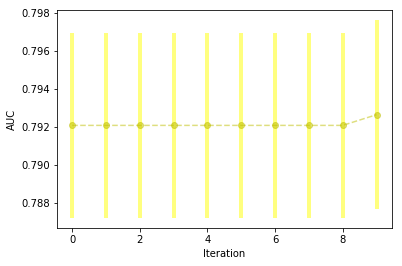

In [10]:
import matplotlib.pyplot as plt

iterations = list(map(lambda iteration: iteration.iteration, experiment.iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, experiment.iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, experiment.iteration_data))

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "y", 
             ecolor='yellow', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.show();

We can access the data used for each visualization shown in the GUI.  Below we examine the gains and lifts table for the test data.

In [11]:
pd.DataFrame(experiment.test_gains.dump())

,gains,lifts,quantiles
0,0.041074,4.107425,0.01
1,0.080569,4.028436,0.02
2,0.120853,4.028436,0.03
3,0.150869,3.771722,0.04
4,0.183254,3.665087,0.05
5,0.341232,3.412322,0.10
6,0.454186,3.027909,0.15
7,0.537915,2.689573,0.20
8,0.654818,2.182728,0.30
9,0.744076,1.860190,0.40


A list of all the attributes of the experiment object are shown below: 

In [12]:
[attr for attr in dir(experiment) if not attr.startswith('__')]

['autoreport_path',
 'clone',
 'dataset_name',
 'deprecated',
 'description',
 'dump',
 'fitted_model_path',
 'ids_col',
 'iteration_data',
 'key',
 'labels',
 'load',
 'log_file_path',
 'max_iterations',
 'mojo_pipeline_path',
 'parameters',
 'patched_pred_contribs',
 'pickle_path',
 'score',
 'scorer',
 'scoring_pipeline_path',
 'summary_path',
 'test_act_vs_pred',
 'test_gains',
 'test_predictions_path',
 'test_roc',
 'test_score',
 'test_score_sd',
 'trace_events',
 'train_predictions_path',
 'training_duration',
 'unfitted_pipeline_path',
 'valid_act_vs_pred',
 'valid_gains',
 'valid_predictions_path',
 'valid_roc',
 'valid_score',
 'valid_score_sd',
 'warnings']

#### Equivalent Steps in Driverless: View Results
![Equivalent Steps in Driverless: View Results](images/experiment_complete_creditcard.png)

### 6. Download Results

Once an experiment is complete, we can see that the UI presents us options of downloading the: 

* predictions on the (holdout) train data
* predictions on the test data
* experiment summary - summary of the experiment including feature importance

We will show an example of downloading the test predictions below.  Note that equivalent commands can also be run for downloading the train (holdout) predictions. 

In [13]:
h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [14]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,default payment next month.0,default payment next month.1
0,0.337645,0.662355
1,0.868740,0.131260
2,0.938929,0.061071
3,0.627814,0.372186
4,0.882489,0.117511


We can also download and examine the summary of the experiment and feature importance for the final model.

In [15]:
# Download Summary
import subprocess
summary_path = h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path = "./h2oai_experiment_summary_" + experiment.key
_ = subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

The table below shows the feature name, its relative importance, and a description.  Some features will be engineered by Driverless AI and some can be the original feature.

In [16]:
# View Features
features = pd.read_table(dir_path + "/features.txt", sep=',', skipinitialspace=True)
features.head(n = 10)

,Relative Importance,Feature,Description
0,1.00000,10_PAY_0,PAY_0 (original)
1,0.80571,23_NumToCatTE:PAY_0.0,Out-of-fold mean of the response grouped by: [...
2,0.44975,11_PAY_2,PAY_2 (original)
3,0.21350,8_LIMIT_BAL,LIMIT_BAL (original)
4,0.20928,12_PAY_3,PAY_3 (original)
5,0.18928,1_BILL_AMT1,BILL_AMT1 (original)
6,0.17247,19_PAY_AMT4,PAY_AMT4 (original)
7,0.17133,16_PAY_AMT1,PAY_AMT1 (original)
8,0.15279,17_PAY_AMT2,PAY_AMT2 (original)
9,0.15051,2_BILL_AMT2,BILL_AMT2 (original)


### 7. Launch Experiment with Config Overrides

We will launch an additional experiment, this time we will override the default configurations.  For this experiment, we will only use the GLM algorithm and we blacklist all target encoding feature transformers.

In [17]:
experiment_glm = h2oai.start_experiment_sync(dataset_key=train.key, 
                                             testset_key=test.key,
                                             target_col=target,
                                             is_classification=True,
                                             accuracy=6,
                                             time=3,
                                             interpretability=6,
                                             scorer="AUC",
                                             seed=1234,
                                             config_overrides='enable_glm="on"\n'
                                                              'enable_xgboost="off"\n'
                                                              'enable_tensorflow="off"\n'
                                                              'enable_rulefit="off"\n'
                                                              'enable_lightgbm="off"\n'
                                                              'black_list_transformers=[\"NumCatTETransformer\", \"CVTargetEncodeF\", \"NumToCatTETransformer\", \"ClusterTETransformer\"]'
                                            )

We can compare the performance between the two experiments:

In [18]:
pd.DataFrame({'experiment': ["default", "glm only"], 
              'test_score': [experiment.test_score, experiment_glm.test_score]})

,experiment,test_score
0,default,0.799748
1,glm only,0.753666


## Build an Experiment in Web UI and Access Through Python

It is also possible to use the Python API to examine an experiment that was started through the Web UI using the experiment key.

![Experiments List](images/experiment_list_complete.png)

### 1. Get pointer to experiment

You can get a pointer to the experiment by referencing the experiment key in the Web UI.

In [19]:
# Get list of experiments
experiment_list = list(map(lambda x: x.key, h2oai.list_models(offset=0, limit=100)))
experiment_list

['bofuseke', 'pacoganu', 'fokahohu', 'ticipucu']

In [20]:
# Get pointer to experiment
experiment = h2oai.get_model_job(experiment_list[0]).entity

## Score on New Data

You can use the python API to score on new data. This is equivalent to the **SCORE ON ANOTHER DATASET** button in the Web UI. The example below scores on the test data and then downloads the predictions.

Pass in any dataset that has the same columns as the original training set. If you passed a test set during the H2OAI model building step, the predictions already exist. Its path can be found with `experiment.test_predictions_path`.

### 1. Score Using the H2OAI Model

The following shows the predicted probability of default for each record in the test.  

In [21]:
prediction = h2oai.make_prediction_sync(experiment.key, test_path, output_margin = False, pred_contribs = False)
pred_path = h2oai.download(prediction.predictions_csv_path, '.')
pred_table = pd.read_csv(pred_path)
pred_table.head()

,default payment next month.0,default payment next month.1
0,0.550874,0.449126
1,0.834274,0.165726
2,0.825403,0.174597
3,0.562074,0.437926
4,0.839018,0.160982


We can also get the contribution each feature had to the final prediction by setting `pred_contribs = True`.  This will give us an idea of how each feature effects the predictions using Shapley.

In [22]:
prediction_contributions = h2oai.make_prediction_sync(experiment.key, test_path, 
                                                      output_margin = False, pred_contribs = True)
pred_contributions_path = h2oai.download(prediction_contributions.predictions_csv_path, '.')
pred_contributions_table = pd.read_csv(pred_contributions_path)
pred_contributions_table.head()

,contrib_0_NumToCatWoE:PAY_0:PAY_2.0,contrib_1_NumToCatWoE:PAY_0:PAY_6.0,contrib_2_NumToCatWoE:BILL_AMT3:PAY_0:PAY_2:PAY_3.0,contrib_3_NumToCatWoE:BILL_AMT3:PAY_0:PAY_2:PAY_3.0,contrib_4_NumToCatWoE:PAY_0:PAY_2:PAY_3.0,contrib_5_NumToCatWoE:PAY_0:PAY_2:PAY_3.0,contrib_6_PAY_2,contrib_7_PAY_0,contrib_8_NumToCatWoE:PAY_0:PAY_2:PAY_6.0,contrib_bias
0,0.092378,0.131496,0.164308,0.175802,0.166487,0.143705,0.0,0.000524,0.120301,-1.199351
1,-0.029177,-0.051891,-0.080473,-0.086486,-0.065098,-0.056233,0.0,0.000000,-0.047549,-1.199351
2,-0.029177,-0.051891,-0.047550,-0.056703,-0.065098,-0.056233,0.0,0.000000,-0.047549,-1.199351
3,0.084217,0.124620,0.150446,0.199787,0.147046,0.103472,0.0,0.001310,0.138215,-1.199351
4,-0.029177,-0.048915,-0.078790,-0.090655,-0.084294,-0.072879,0.0,0.000000,-0.047054,-1.199351


We will examine the contributions for the first customer more closely.

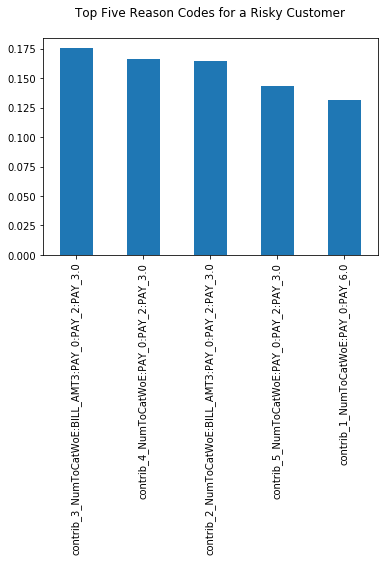

In [23]:
%matplotlib inline

contrib =pred_contributions_table.iloc[0, :-1].to_frame(name = "contribution")
contrib["abs_contribution"] = contrib.contribution.abs()
contrib = contrib.sort_values(by="abs_contribution", ascending=False)[["contribution"]]

_ = contrib[:5].plot(kind='bar', 
                     title='Top Five Reason Codes for a Risky Customer\n', 
                     legend=False)

The Weight of Evidence of the columns: `BILL_AMT3`, `PAY_0`, `PAY_2`, `PAY_3` had the greatest impact on their prediction.  Since the contribution is positive, we know that it increases the probability that they will default.

## Run Model Interpretation

Once we have completed an experiment, we can interpret our H2OAI model.  Model Interpretability is used to provide model transparency and explanations.  More information on Model Interpretability can be found here: http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/interpreting.html.


### 1. Run Model Interpretation on Driverless AI Experiment

We can run the model interpretation in the python client as shown below. 

In [24]:
mli_experiment = h2oai.run_interpretation_sync(dai_model_key=experiment.key, 
                                               dataset_key=train.key, 
                                               target_col=target)

This is equivalent to clicking **Interpret this Model** in the UI once the experiment has completed.

![Equivalent Steps in Driverless: View Results](images/experiment_complete_creditcard.png)

Once our interpretation is finished, we can navigate to the MLI tab in the UI to see our interpreted model. 

![Equivalent Steps in Driverless: MLI List](images/mli_list.png)

We can also see the list of interpretations using the Python Client:

In [25]:
# Get list of interpretations
mli_list = list(map(lambda x: x.key, h2oai.list_interpretations(offset=0, limit=100)))
mli_list

['gonelugu']

### 2. Run Model Interpretation on External Model Predictions

Model Interpretation does not need to be run on a Driverless AI experiment.  We can also train an external model and run Model Interpretability on the predictions. In this next section, we will walk through the steps to interpret an external model.

#### Train External Model

We will begin by training a model with scikit-learn.  Our end goal is to use Driverless AI to interpret the predictions made by our scikit-learn model.

In [26]:
# Dataset must be located where python client is running
train_pd = pd.read_csv(train_path)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

predictors = list(set(train_pd.columns) - set([target]))

gbm_model = GradientBoostingClassifier(random_state=10)
gbm_model.fit(train_pd[predictors], train_pd[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
predictions = gbm_model.predict_proba(train_pd[predictors])
predictions[0:5]

array([[0.38111179, 0.61888821],
       [0.44396186, 0.55603814],
       [0.91738328, 0.08261672],
       [0.88780536, 0.11219464],
       [0.80028008, 0.19971992]])

#### Interpret on External Predictions

Now that we have the predictions from our scikit-learn GBM model, we can call Driverless AI's `h2o_ai.run_interpretation_sync` to create the interpretation screen.

In [29]:
train_gbm_path = "./CreditCard-train-gbm_pred.csv"
predictions = pd.concat([train_pd, pd.DataFrame(predictions[:, 1], columns = ["p1"])], axis = 1)
predictions.to_csv(path_or_buf=train_gbm_path, index = False)

In [30]:
train_gbm_pred = h2oai.upload_dataset_sync(train_gbm_path)

In [31]:
mli_external = h2oai.run_interpretation_sync(dai_model_key = "", #we are interpreting an external model
                                             dataset_key=train_gbm_pred.key, 
                                             target_col=target, # target column used by external model
                                             prediction_col="p1", # column with external model's predictions
                                            )

We can also run Model Interpretability on an external model in the UI as shown below:

![Equivalent Steps in Driverless: MLI External Model](images/mli_external.png)

In [32]:
# Get list of interpretations
mli_list = list(map(lambda x: x.key, h2oai.list_interpretations(offset=0, limit=100)))
mli_list

['kilegodu', 'gonelugu']

## Build Scoring Pipelines

In our last section, we will build the scoring pipelines from our experiment.  There are two scoring pipeline options: 

* Python Scoring Pipeline: requires Python runtime
* MOJO Scoring Pipeline: requires Java runtime

Documentation on the scoring pipelines is provided here: http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python-mojo-pipelines.html.

![Equivalent Steps in Driverless: View Results](images/experiment_complete_creditcard.png)

The experiment screen shows two scoring pipeline buttons: **Download Python Scoring Pipeline** or **Build MOJO Scoring Pipeline**.  Driverless AI determines if any scoring pipeline should be automatically built based on the `config.toml` file.  In this example, we have run Driverless AI with the settings: 

```
# Whether to create the Python scoring pipeline at the end of each experiment
make_python_scoring_pipeline = true

# Whether to create the MOJO scoring pipeline at the end of each experiment
# Note: Not all transformers or main models are available for MOJO (e.g. no gblinear main model)
make_mojo_scoring_pipeline = false
```

Therefore, only the Python Scoring Pipeline will be built by default.

### 1. Build Python Scoring Pipeline

The Python Scoring Pipeline has been built by default based on our `config.toml` settings.  We can get the path to the Python Scoring Pipeline in our experiment object.

In [33]:
experiment.scoring_pipeline_path

'h2oai_experiment_bofuseke/scoring_pipeline/scorer.zip'

We can also build the Python Scoring Pipeline - this is useful if the `make_python_scoring_pipeline` option was set to false.

In [34]:
python_scoring_pipeline = h2oai.build_scoring_pipeline_sync(experiment.key)

In [35]:
python_scoring_pipeline.file_path

'h2oai_experiment_bofuseke/scoring_pipeline/scorer.zip'

Now we will download the scoring pipeline zip file.

In [36]:
h2oai.download(python_scoring_pipeline.file_path, dest_dir=".")

'./scorer.zip'

### 2. Build MOJO Scoring Pipeline

The MOJO Scoring Pipeline has not been built by default because of our `config.toml` settings.  We can build the MOJO Scoring Pipeline using the Python client.  This is equivalent to selecting the **Build MOJO Scoring Pipeline** on the experiment screen.

In [37]:
mojo_scoring_pipeline = h2oai.build_mojo_pipeline_sync(experiment.key)

In [38]:
mojo_scoring_pipeline.file_path

'h2oai_experiment_bofuseke/mojo_pipeline/mojo.zip'

Now we can download the scoring pipeline zip file.

In [39]:
h2oai.download(mojo_scoring_pipeline.file_path, dest_dir=".")

'./mojo.zip'

Once the MOJO Scoring Pipeline is built, the **Build MOJO Scoring Pipeline** changes to **Download MOJO Scoring Pipeline**.



![Equivalent Steps in Driverless: Download MOJO](images/download_mojo.png)